# INF-0616 - Projeto 3: Redes neurais

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- a229999@dac.unicamp.br
           Hudson Bruno -- hudson.bruno@ic.unicamp.br 

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=456)

Download do dataset: [download dataset customer-issues](https://ic.unicamp.br/~esther/customer-issues.csv)


Instituto de Computação - Unicamp 2020

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

In [2]:
np.random.seed(12049)

plt.rcParams['figure.figsize'] = (12, 6)

#### Lendo o conjunto de dados

O conjunto de dados consiste em reclamações de clientes a cerca de produtos/serviços oferecidos em uma instituição bancária. ***Garanta que o arquivo*** `customer-issues.csv` ***está no mesmo diretório do notebook***.

In [3]:
d = pd.read_csv('/home/dani/Documentos/curso unicamp/Aprendizado de Máquina Supervisionado II/Trabalho/Trabalho_3/customer-issues.csv')
display(d.head())

,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


##### Exibindo as quatro primeiras mensagens

In [4]:
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

##### Extraíndo um conjunto de testes válido

As mensagens contidas neste conjunto possuem uma relação temporal.
É importante realizar a separação dos sub-conjuntos de treino/teste respeitando esta relação, de forma a garantir que o modelo não seja treinado sobre amostras no futuro e experimentado sobre o passado.

In [5]:
d.sort_values(by='date-received', inplace=True)

### Modelando a classificação de tópicos baseado nas mensagens de clientes

Observando no gráfico de frequências de produto sobre as conversas que este é um problema extremamente desbalanceado. Há, entretanto, amostras suficientes para a modelagem de um estimador de tópico (de produto) levando em consideração o diálogo do cliente.

In [6]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]
    
    (sns
     .barplot([l[:40] for l in labels], counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)
    
    return labels, counts

/home/dani/anaconda3/envs/env_deep/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


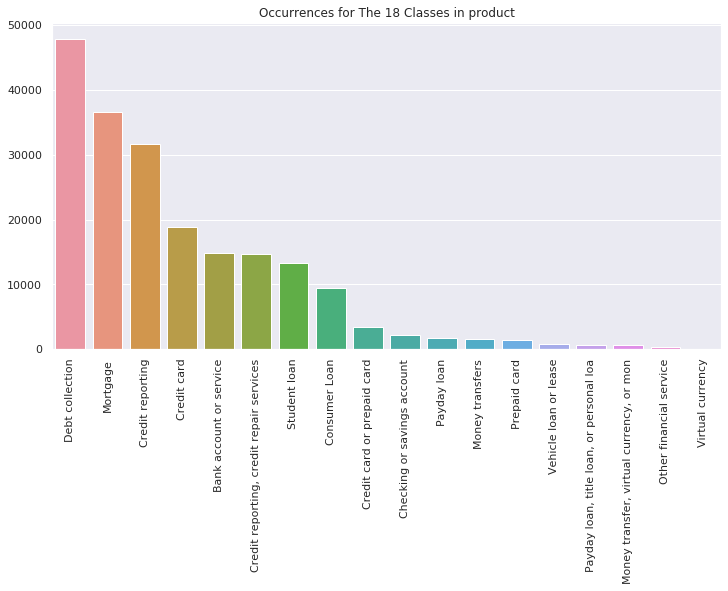

In [7]:
labels, counamts = frequencies(d, 'product')

Simplificamos o problema, considerando somente as 6 classes mais frequentes:

In [8]:
s = d['product'].isin(labels[:6])
d = d[s]

test_share = .3

d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

Vamos codificar as palavras na conversa utilizando o TF-IDF, gerando um vetor de características baseadas nas frequências de ocorrência das palavras no documento e em todo o conjunto de dados.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

## Treinando um regressor logístico para classificar produto
**Atividade (1 pt):** treine um regressor logístico, buscando os hiper-parâmetros com *grid-search*.

Iremos calcular a matriz de confusão relativa $R$, que guarda porcentagens de incidências em vez das contagens absolutas, e plotar o heatmap dessa matriz. Além disso, iremos calcular a distribuição de confiança nas predições por classe (mais próximos de `1.0` --> mais confiante):

In [10]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))
    
    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)
    
    # Impressão dos gráficos.
    (plt
     .figure(figsize=(16, 12))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)

    (plt
     .figure(figsize=(16, 12))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))
    
    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        sns.distplot(probabilities[y.ravel() == i][:, i],
                     hist=False,
                     label=labels[i])

Vamos utilizar a função `evaluate` para avaliar o modelo treinado anteriormente:

In [11]:
#evaluate(ye_test, g.predict(x_test), g.predict_proba(x_test), labels=label_enc.classes_)

**Pergunta (1pt):** considerando o gráfico de distribuição de confiança para o seu modelo treinado, as amostras são classificadas com alta confiança? Há uma grande diferença de confiança entre as diferentes classes?

----------
----------

## Redes Neurais
Iremos treinar alguns modelos de redes neurais, variando número de camadas e quantidade de neurônios em cada camada.

In [12]:
epochs = 10
BATCH_SIZE = 128
input_shape = [features]

**As 6 primeiras labels**
1. Debt collection
2. Mortgage
3. Credit reporting
4. Credit card
5. Bank account or service
6. Credit reporting

In [13]:
input_shape

[1024]

Vamos converter os rótulos em vetores *One Hot Encoded*:

In [14]:
from keras.utils import np_utils
y_ohe_train = np_utils.to_categorical(ye_train, num_classes=6)
y_ohe_test = np_utils.to_categorical(ye_test, num_classes=6)

Using TensorFlow backend.
/home/dani/anaconda3/envs/env_deep/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dani/anaconda3/envs/env_deep/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dani/anaconda3/envs/env_deep/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dani/anaconda3

In [15]:
y_ohe_train.shape

(115143, 6)

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema. 

**Construindo a arquitetura com o Keras** 

In [16]:
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Activation, Input
from tensorflow import keras
from keras.optimizers import SGD
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [17]:
num_classes=6

**Instanciado o otimizador, com uma taxa inicial de learning rate**

In [18]:
def get_optimizer_sgd():
  return SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

**Criando o modelo modelo com a API funcional do keras**

In [19]:
ipt = Input(shape = (1024,))
x = Dense(512, activation='relu')(ipt)
y = Dense(512, activation='relu')(x)
out = Dense(num_classes, activation='softmax')(y)
model = Model(inputs=ipt, outputs=out)

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 3078      
Total params: 790,534
Trainable params: 790,534
Non-trainable params: 0
_________________________________________________________________


**Copilando o modelo**

In [21]:
model.compile(loss='categorical_crossentropy', optimizer=get_optimizer_sgd(), metrics=['accuracy'])

### Treinando a rede neural

**Atividade (1 pt):** treine o modelo definido acima sobre o conjunto, respeitando as seguintes regras:

1. Separe um subconjunto do treino para validação.
2. Utilize alguma técnica para conservar os parâmetros que melhor generalizam o problema, como `ModelCheckpoint` (salve o modelo com nome de `weights.h5`).

**1.Separando um subconjunto do treino para validação**

In [22]:
x_train, x_val, y_ohe_train, ye_val= train_test_split(x_train, y_ohe_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [23]:
y_ohe_train.shape

(86357, 6)

In [24]:
ye_val.shape

(28786, 6)

**2.Criando o Model Checkpoint**

In [25]:
from keras.callbacks import ModelCheckpoint

In [26]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="weights.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

**Iniciando o processo de treinamento**

In [27]:
history = model.fit(
      x_train, 
      y_ohe_train,
      batch_size=BATCH_SIZE,
      epochs=epochs,
      verbose=1,
      callbacks=[model_checkpoint_callback],
      validation_data=(x_val, ye_val),
    )


Train on 86357 samples, validate on 28786 samples
Epoch 1/10
86357/86357 [==============================] - 6s 69us/step - loss: 0.6120 - accuracy: 0.7908 - val_loss: 0.5263 - val_accuracy: 0.8222
Epoch 2/10
86357/86357 [==============================] - 6s 69us/step - loss: 0.4055 - accuracy: 0.8644 - val_loss: 0.5052 - val_accuracy: 0.8322
Epoch 3/10
86357/86357 [==============================] - 6s 71us/step - loss: 0.2969 - accuracy: 0.9029 - val_loss: 0.5100 - val_accuracy: 0.8392
Epoch 4/10
86357/86357 [==============================] - 7s 83us/step - loss: 0.1956 - accuracy: 0.9396 - val_loss: 0.5409 - val_accuracy: 0.8394
Epoch 5/10
86357/86357 [==============================] - 7s 79us/step - loss: 0.1156 - accuracy: 0.9683 - val_loss: 0.5895 - val_accuracy: 0.8413
Epoch 6/10
86357/86357 [==============================] - 6s 73us/step - loss: 0.0648 - accuracy: 0.9852 - val_loss: 0.6413 - val_accuracy: 0.8432
Epoch 7/10
86357/86357 [==============================] - 6s 73us/s

In [28]:
model.save('my_model_save.h5')

In [29]:
#model.load_weights('/home/dani/Documentos/curso unicamp/Aprendizado de Máquina Supervisionado II/Trabalho/Trabalho_3/assignment-3.ipynb/weights.h5')

O método `model.fit` retorna `model.history`, e contem algumas informações interessantes a respeito do histórico de treinamento.

**Atividade (1 pt):** plote um gráfico de linhas exibindo a evolução dos valores da função *loss* sobre o conjunto de treino e validação. A partir de qual `epoch` a rede começou a super-especializar?

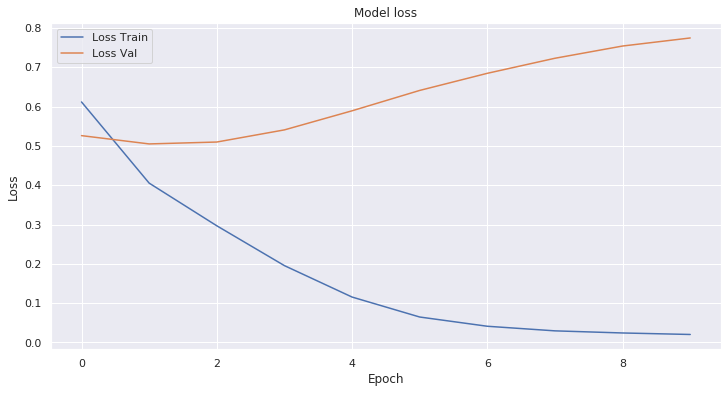

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss Train', 'Loss Val'], loc='upper left')
plt.show()

### Avaliando o modelo treinado

**Atividade (1 pt):** teste o modelo treinado utilizando o subconjunto de teste. Reporte a acurácia para cada classe e a matriz de confusão percentual (usando a função `evaluate` definida anteriormente).

In [31]:
(loss, accuracy) = model.evaluate(x_test, y_ohe_test, verbose=1)

49347/49347 [==============================] - 2s 45us/step


In [32]:
model_predict = model.predict(x_test)

In [33]:
#model_proba = model.metrics

In [34]:
#evaluate(y_ohe_test, model_predict, model_proba, labels=label_enc.classes_)

--------

Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

**Criando o modelo 2 como um modelo sequencial**

In [35]:
from keras.layers import Dropout

In [36]:
model2 = Sequential()
model2.add(Dense(1024, activation='relu', input_shape=(1024,)))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(280, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))

**Copilando o modelo 2**

In [37]:
model2.compile(loss='categorical_crossentropy', optimizer=get_optimizer_sgd(), metrics=['accuracy'])

In [38]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 280)               143640    
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 1686      
Total params: 2,245,038
Trainable params: 2,245,038
Non-trainable params: 0
____________________________________________

**Atividade (1 pt):** treine a nova rede.

In [39]:
model2_checkpoint_callback = ModelCheckpoint(
    filepath="weights2.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [40]:
history_2 = model2.fit(
      x_train, 
      y_ohe_train,
      batch_size=BATCH_SIZE,
      epochs=epochs,
      verbose=1,
      callbacks=[model2_checkpoint_callback],
      validation_data=(x_val, ye_val),
    )

Train on 86357 samples, validate on 28786 samples
Epoch 1/10
86357/86357 [==============================] - 16s 188us/step - loss: 0.6378 - accuracy: 0.7791 - val_loss: 0.5330 - val_accuracy: 0.8187
Epoch 2/10
86357/86357 [==============================] - 15s 179us/step - loss: 0.3988 - accuracy: 0.8642 - val_loss: 0.5013 - val_accuracy: 0.8336
Epoch 3/10
86357/86357 [==============================] - 15s 179us/step - loss: 0.2694 - accuracy: 0.9100 - val_loss: 0.5255 - val_accuracy: 0.8400
Epoch 4/10
86357/86357 [==============================] - 16s 180us/step - loss: 0.1570 - accuracy: 0.9485 - val_loss: 0.6244 - val_accuracy: 0.8316
Epoch 5/10
86357/86357 [==============================] - 16s 180us/step - loss: 0.0928 - accuracy: 0.9700 - val_loss: 0.6689 - val_accuracy: 0.8435
Epoch 6/10
86357/86357 [==============================] - 15s 179us/step - loss: 0.0679 - accuracy: 0.9781 - val_loss: 0.7713 - val_accuracy: 0.8458
Epoch 7/10
86357/86357 [==============================] 

**Atividade (1 pt):** adicione dropout ou regularização L1/L2 e treine o novo modelo. Se for, preciso, faça uma busca pelos hipeparâmetros da regularização/dropout.

**Atividade (1 pt):** avalie os modelos treinados e compare com os resultados anteriores.

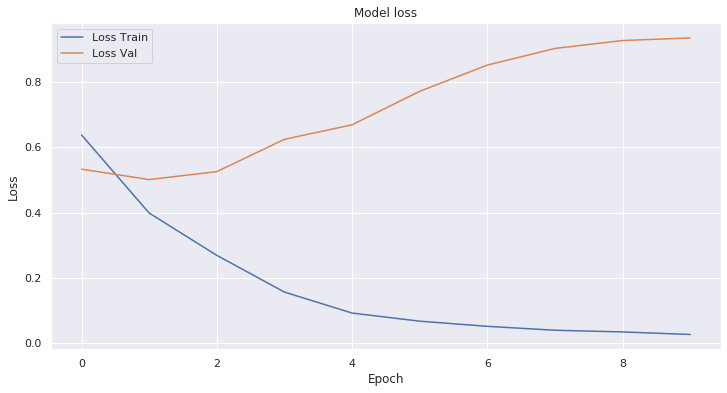

In [41]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss Train', 'Loss Val'], loc='upper left')
plt.show()